# Working with NOAA GHCN data using Python, Pandas, and PyAthena

We use PyAthena for running the queries and Pandas for the results.

## Introduction to NOAA GHCN Data

The NOAA Global Historical Climatology Network (GHCN) is made up of daily observations over global land areas. It contains station-based measurements from land-based stations worldwide, about two thirds of which are for precipitation measurement only. Other meteorological elements include, but are not limited to, daily maximum and minimum temperature, temperature at the time of observation, snowfall and snow depth.

The data are stored on S3 in the bucket `s3://noaa-ghcn-pds/` as fixed width text files. 

We will take advantage of Athena's ability to run queries over objects in S3 buckets, and use it for digesting the GHCN data into manageable pieces. 

In [1]:
from pyathena import connect
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

The `athena_data_bucket` variable is where we will store our query results automatically from Athena. This bucket will be created for you if it does not exist. If it does exist, you will need write access to the bucket.

In [2]:
athena_data_bucket = "ghcn-demo-bucket"
conn = connect(s3_staging_dir="s3://" + athena_data_bucket,
               region_name="us-east-1")

### Create the Athena database & table if it doesn't exist

We create this table using the GHCN data so that Athena knows what the columns represent. For convience, we have converted a static copy of the dataset to Parquet that we will use here.

In [3]:
database = """
CREATE DATABASE IF NOT EXISTS ghcn;
"""

cursor = conn.cursor()
cursor.execute(database)
print(cursor.fetchall())

[]


In [4]:
table = """
CREATE EXTERNAL TABLE IF NOT EXISTS ghcn.dailydata (
  `id` string,
  `year_date` string,
  `element` string,
  `data_value` string,
  `m_flag` string,
  `q_flag` string,
  `s_flag` string,
  `obs_time` string
 )
STORED AS PARQUET
LOCATION 's3://aws-opendata-staging-experiment/ghcn/parquet';
"""

cursor = conn.cursor()
cursor.execute(table)
print(cursor.fetchall())

[]


If the table already exists, and you want to recreate it you can uncomment the `cursor.execute(table)` below and rerun the cell above.

In [5]:
drop = """
DROP TABLE ghcn.dailydata;
"""

#cursor.execute(drop)
#print(cursor.fetchall())

Create a table for the GHCN station data too, so we can have the station metadata

In [6]:
station_table = """
CREATE EXTERNAL TABLE IF NOT EXISTS ghcn.stations (
  `id` string,
  `latitude` float,
  `longitude` float,
  `elevation` float,
  `state` string,
  `location` string,
  `gsn_flag` string,
  `hcn_flag` string,
  `wmo_id` string 
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
WITH SERDEPROPERTIES (
  'serialization.format' = ',',
  'field.delim' = ','
) LOCATION 's3://aws-opendata-staging-experiment/ghcn/stations/'
TBLPROPERTIES ('has_encrypted_data'='false');
"""

cursor = conn.cursor()
cursor.execute(station_table)
print(cursor.fetchall())

[]


## Plot time series Temperature
### Query to get the max air temperature for the Oklahoma City Airport station.

We select the maximum daily air temperature for the Oklahoma City Airport. Select stations using the station list at [GHCN Station List](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt). The [GHCN Element Documentation](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf) describes all of the available elements in the data.

In [7]:
df = pd.read_sql("SELECT data_value, year_date FROM ghcn.dailydata_pq where id = 'USW00013967' and element = 'TMAX' ORDER BY year_date ASC;", conn)
df

,data_value,year_date
0,-28,19480101
1,39,19480102
2,106,19480103
3,89,19480104
4,100,19480105
...,...,...
26113,333,20190705
26114,311,20190706
26115,344,20190707
26116,333,20190708


### Get datetime object & convert C to F

The data stored in GHCN as scaled integers, so we first unscale (divide by 10) then convert to Fahrenheit

In [8]:
df['year_date'] = pd.to_datetime(df.year_date, format='%Y%m%d')
df['air_temp'] = (df.data_value.astype(float) / 10.0) * (9/5) + 32
df

,data_value,year_date,air_temp
0,-28,1948-01-01,26.96
1,39,1948-01-02,39.02
2,106,1948-01-03,51.08
3,89,1948-01-04,48.02
4,100,1948-01-05,50.00
...,...,...,...
26113,333,2019-07-05,91.94
26114,311,2019-07-06,87.98
26115,344,2019-07-07,93.92
26116,333,2019-07-08,91.94


### Plot the time series of temperature and dewpoint

Text(0, 0.5, 'Temperature (F)')

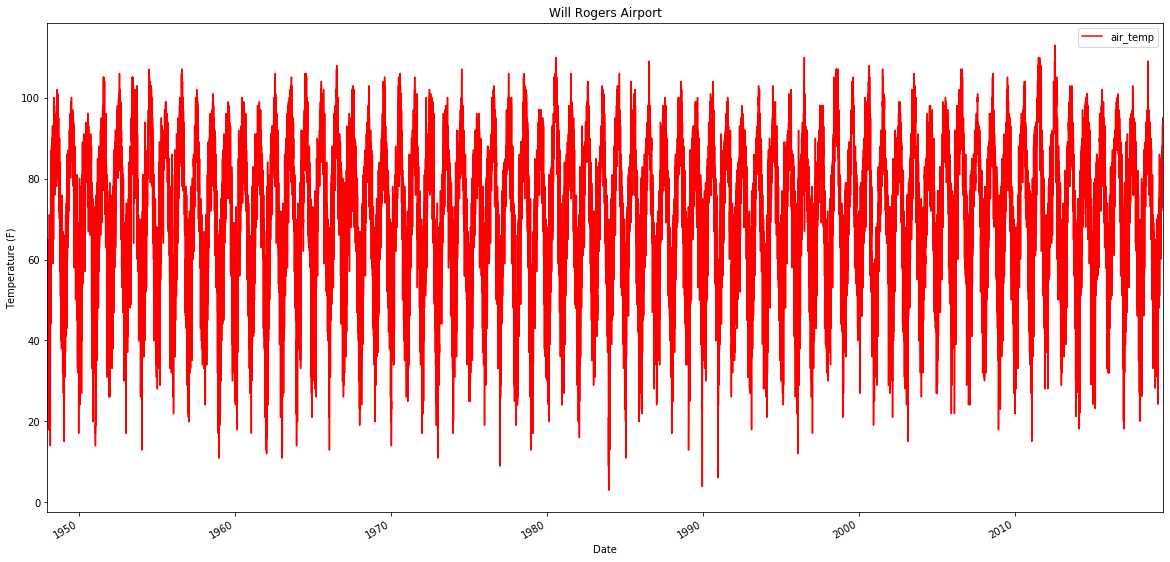

In [9]:
ax = plt.gca()
df.plot(figsize=(20,10), title='Will Rogers Airport', kind='line', x='year_date', y='air_temp', color='red', ax=ax)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

## Plot locations of all stations in GHCN

In [10]:
df = pd.read_sql("SELECT DISTINCT id, wmo_id, latitude, longitude FROM ghcn.stations;", conn)
df

,id,wmo_id,latitude,longitude
0,AFM00040948,None,34.5660,69.2120
1,AGE00147704,None,36.9700,7.7900
2,AJ000037985,None,38.7500,48.8170
3,AR000087270,None,-29.1830,-59.7000
4,ASN00002015,None,-18.4086,127.3547
...,...,...,...,...
113928,USW00094822,None,42.1928,-89.0931
113929,UY000001374,None,-31.5700,-55.4700
113930,VE000080462,None,4.6000,-61.1170
113931,VEM00080410,None,10.0430,-69.3590


Plot a map, and plot the locations of the stations

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


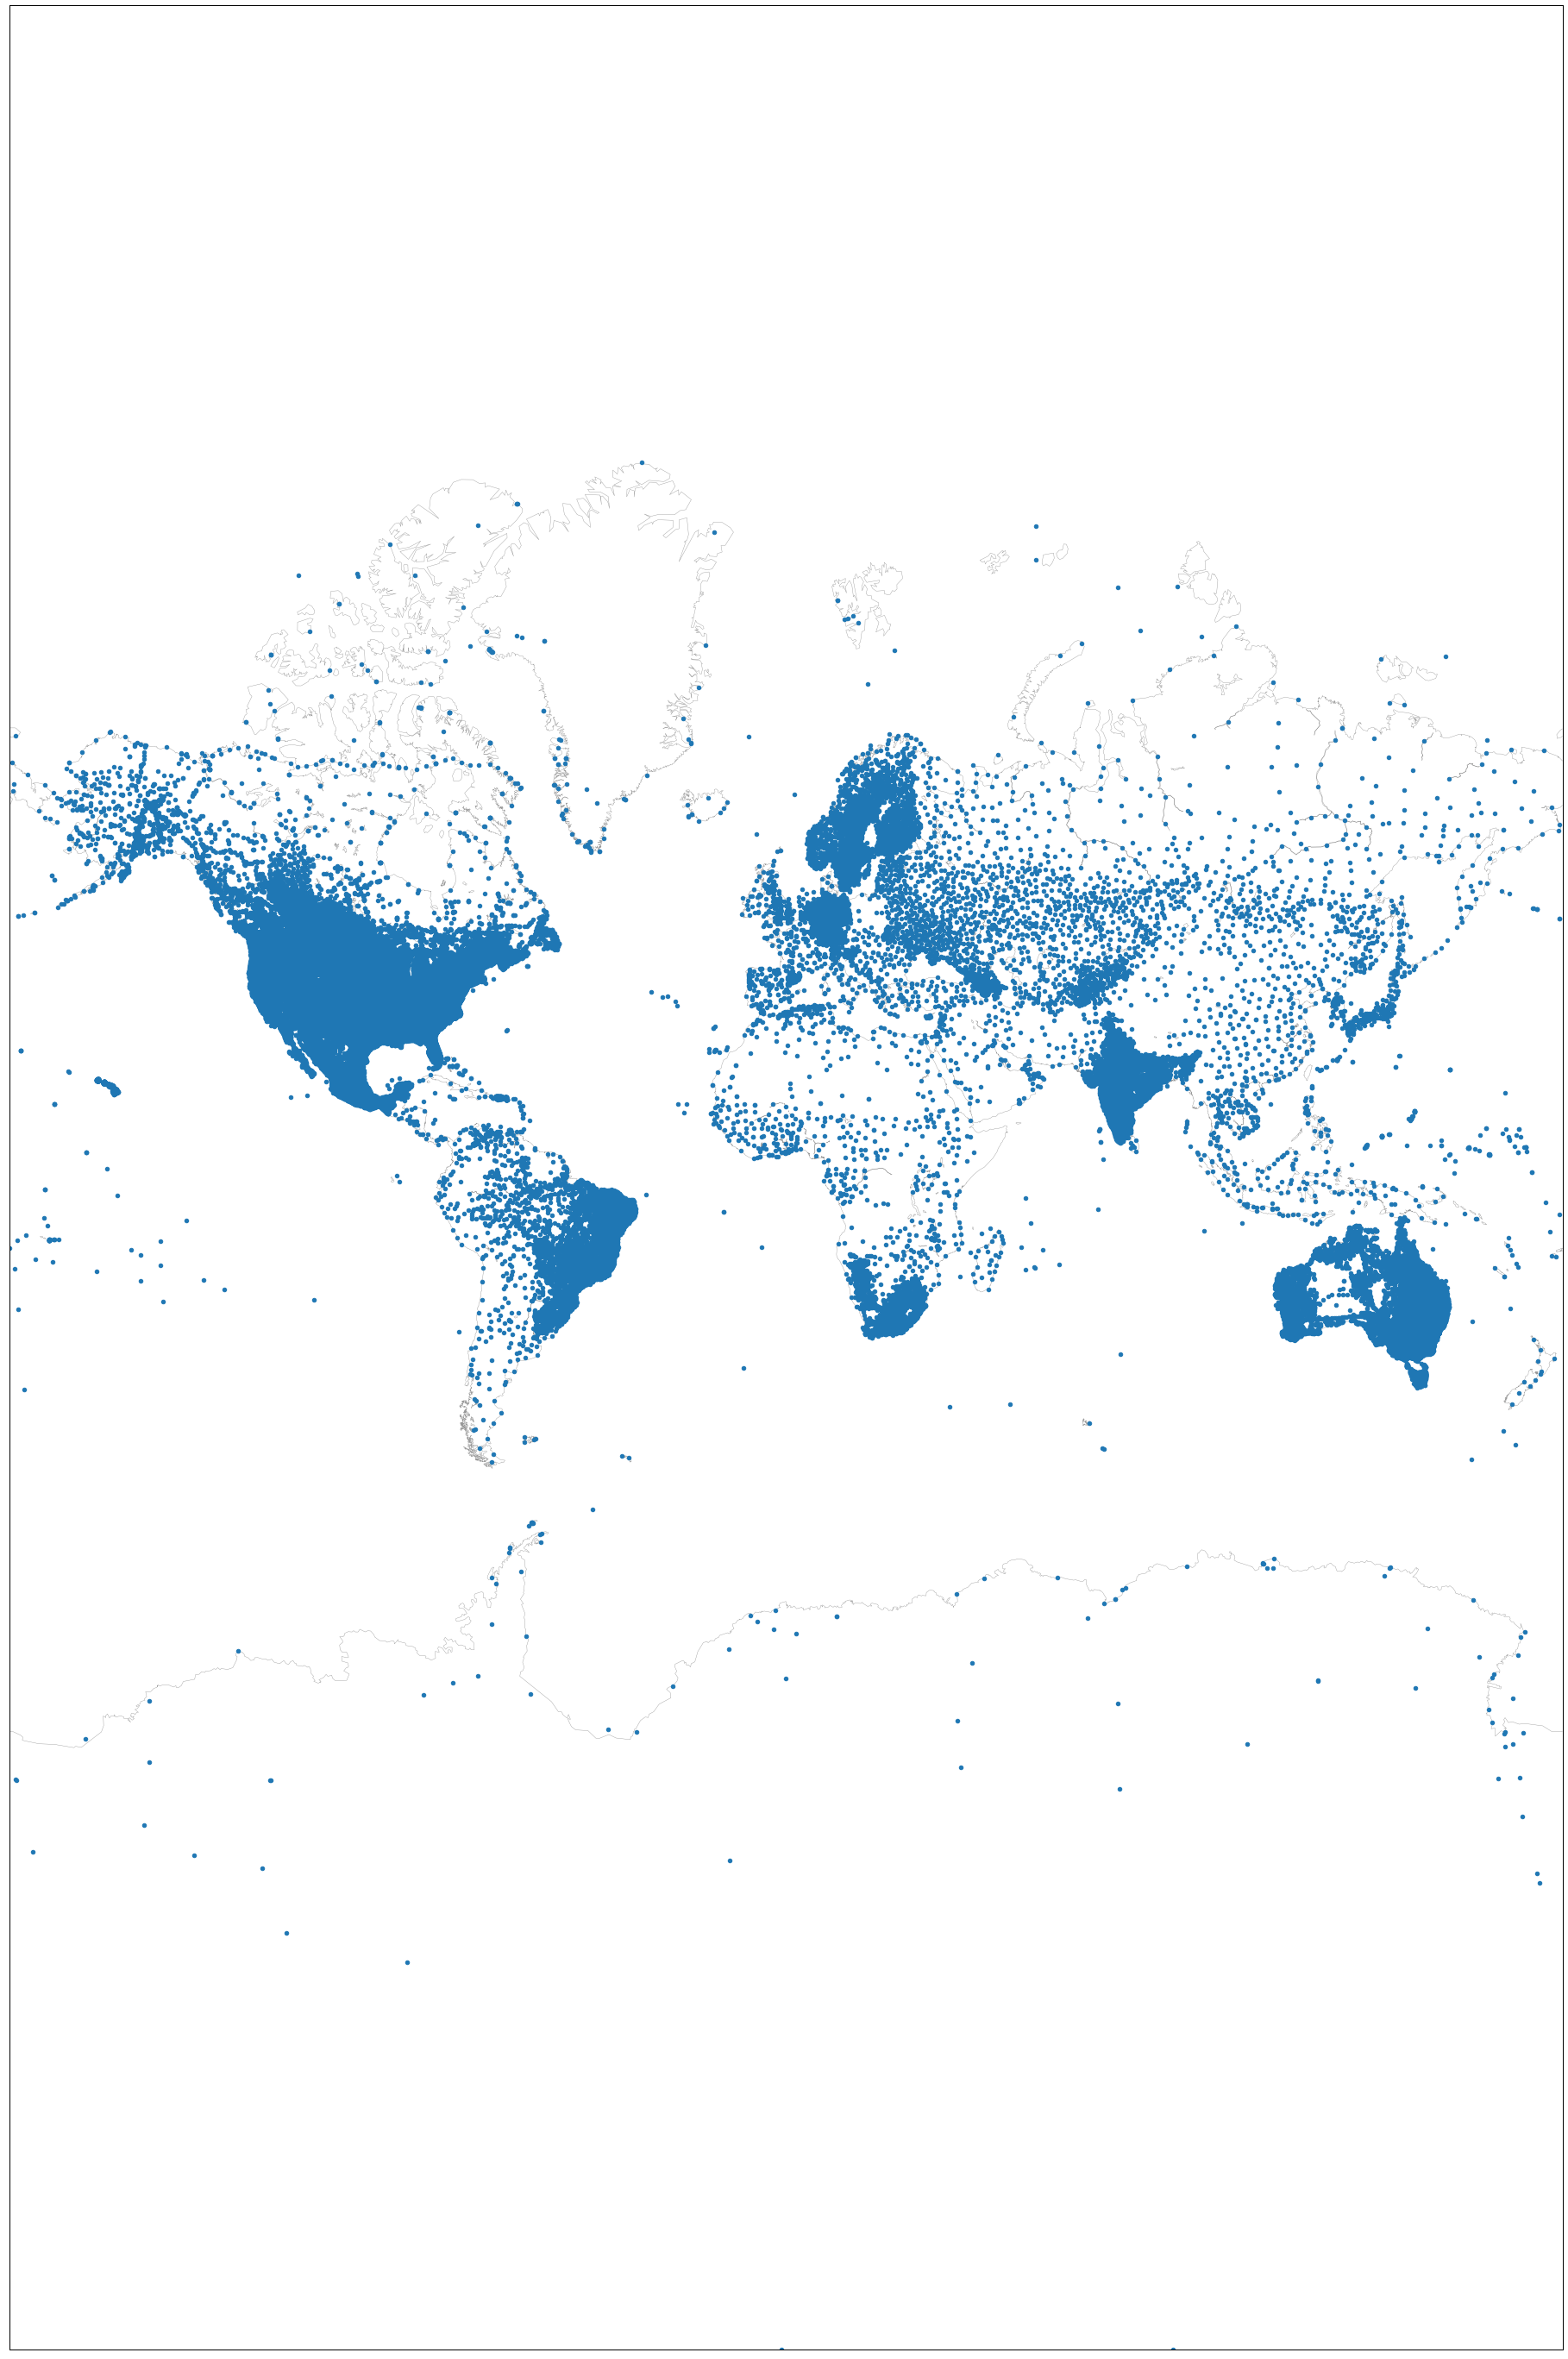

In [11]:
plt.subplots(figsize=(50,50))
m = Basemap(
    projection='merc', 
    llcrnrlat=-89.0, 
    urcrnrlat=89.0, 
    llcrnrlon=-180.0, 
    urcrnrlon=180.0,
    resolution='l'
)

m.drawmapboundary(fill_color='#ffffff')
m.drawcoastlines(color='#999999', linewidth=.4)

m.scatter(df.longitude.tolist(), df.latitude.tolist(), s=20, zorder=2, latlon=True)

plt.show()

## Does a cold November mean a snowy December?

Often early season cold leads people to believe that the winter will be harsh. Is there any validity to that claim? Here we will explore if there is a correlation between the average temperature in November and the total snow fall accumulation in December.

We picked our favorite station to try this out on, Chicago!

We wrote a more complicated Athena SQL query to pull out the exact information we want.

In [12]:
sql = """
With max_t as (SELECT AVG(CAST(data_value AS DOUBLE)/10.0) AS avg_nov_max_t,
         SUBSTR(year_date,
        1,
        4) AS year
FROM ghcn.dailydata
WHERE id = 'USW00094846'
        AND element = 'TMAX'
        AND SUBSTR(year_date,5,2) = '11'
GROUP BY  SUBSTR(year_date,1,4)
),

snow as (SELECT SUM(CAST(data_value AS DOUBLE)/100.0) AS sum_dec_snow,
         SUBSTR(year_date,
        1,
        4) AS year
FROM ghcn.dailydata
WHERE id = 'USW00094846'
        AND element = 'SNOW'
        AND SUBSTR(year_date,5,2) = '12'
GROUP BY  SUBSTR(year_date,1,4)
)

SELECT max_t.avg_nov_max_t, snow.sum_dec_snow, snow.year
FROM max_t LEFT OUTER JOIN snow
ON max_t.year = snow.year WHERE snow.year <> '' ORDER BY year DESC;
"""
df = pd.read_sql(sql, conn)
df

,avg_nov_max_t,sum_dec_snow,year
0,4.306667,0.36,2018
1,8.296667,1.35,2017
2,12.926667,4.51,2016
3,12.053333,1.14,2015
4,5.256667,0.00,2014
...,...,...,...
56,9.956667,0.60,1962
57,8.736667,2.72,1961
58,9.850000,1.07,1960
59,4.223333,1.76,1959


In [13]:
df['year'] = pd.to_datetime(df.year, format='%Y')
df['avg_nov_max_t'] = (df.avg_nov_max_t.astype(float)) * (9/5) + 32
df

,avg_nov_max_t,sum_dec_snow,year
0,39.752,0.36,2018-01-01
1,46.934,1.35,2017-01-01
2,55.268,4.51,2016-01-01
3,53.696,1.14,2015-01-01
4,41.462,0.00,2014-01-01
...,...,...,...
56,49.922,0.60,1962-01-01
57,47.726,2.72,1961-01-01
58,49.730,1.07,1960-01-01
59,39.602,1.76,1959-01-01


Text(0, 0.5, 'Decembmer Snow (in)')

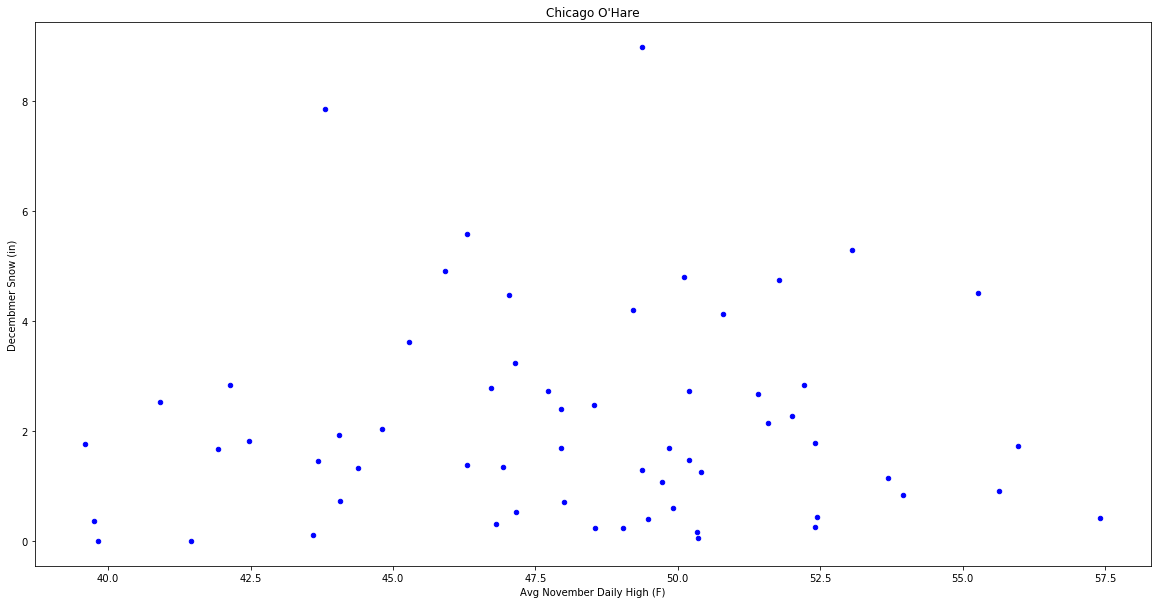

In [14]:
ax = plt.gca()
df.plot(figsize=(20,10), title='Chicago O\'Hare', kind='scatter', x='avg_nov_max_t', y='sum_dec_snow', color='blue', ax=ax)
plt.xlabel('Avg November Daily High (F)')
plt.ylabel('Decembmer Snow (in)')